# Fine Tuning Transformer for MultiLabel Text Classification

In [1]:
# Importing stock ml libraries
import numpy as np
import pandas as pd
from sklearn import metrics, preprocessing
from sklearn.model_selection import train_test_split
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import RobertaTokenizer, RobertaConfig, RobertaModel
import matplotlib.pyplot as plt
import seaborn as sns

//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
//anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1)

In [2]:
# Setting up device for GPU usage

from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

### Importing and Pre-Processing the domain data

In [3]:
df = pd.read_csv('changedoriginalratings0MasterAffectEventReduced.csv')

g0df = df[['Affect', 'Original StoryID', 'Original text', 'Affect Rating']]
g1df = df[['G1 Story', 'G1 WC', 'G1 StoryID', 'G1 Affect Rating', 'G1 emotional effect', 'G1 Transport',
            'G1 Event Presence', 'G1 Gender', 'G1 Age', 'G1 Native Lang', 'G1 Edu', 'G1 Reading habits']]
g2df = df[['G2 Retelling', 'G2 WC', 'G2 StoryID', 'G2 Affect Rating', 'G2 Event Presence', 'G2 Gender', 
           'G2 Age','G2 Native Lang', 'G2 Edu', 'G2 Reading habits']]
g3df = df[['G3 Retelling', 'G3 WC', 'G3 StoryID', 'G3 Affect Rating', 'G3 emotional effect', 'G3 Transport',
           'G3 Event Presence', 'G3 Gender', 'G3 Age', 'G3 Native Lang', 'G3 Edu', 'G3 Reading habits']]

In [4]:
# Create 15 classes of emotion plus intensity
def create_affect_level_class(affect_rating):
    affect_level = []
    for i, rating in enumerate(affect_rating):
        if rating < 7/3:
            affect_level.append(g0df['Affect'][i]+' Low')
        elif rating > 14/3:
            affect_level.append(g0df['Affect'][i]+' High')
        else: # Imputes moderate class for NaN values
            affect_level.append(g0df['Affect'][i]+' Moderate')
    return np.array(affect_level) # Length of 8576

g0_affect_level = create_affect_level_class(g0df['Affect Rating'])
g1_affect_level = create_affect_level_class(g1df['G1 Affect Rating'])
g2_affect_level = create_affect_level_class(g2df['G2 Affect Rating'])
g3_affect_level = create_affect_level_class(g3df['G3 Affect Rating'])

In [8]:
le = preprocessing.LabelBinarizer()
# One-hot encode training labels
Y_g1 = le.fit_transform(g1_affect_level).tolist()
g1stories = g1df['G1 Story'].values

# One-hot encode validation labels
Y_g2 = le.fit_transform(g2_affect_level).tolist()
g2stories = g2df['G2 Retelling'].values

In [7]:
d = {'text': g1stories, 'affect': Y_g1}
new_df = pd.DataFrame(data=d)
new_df.head()

,text,affect
0,a couple travels through asia. they both love ...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,a couple travels through asia. they both love ...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,a couple travels through asia. they both love ...,"[0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,Arnold and his girlfriend Elizabeth both enjoy...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,Arnold and his girlfriend Elizabeth both enjoy...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [8]:
d2 = {'text': g2stories, 'affect': Y_g2}
test_df = pd.DataFrame(data=d2)
test_df.head()

,text,affect
0,"A couple was traveling through Asia, doing tou...","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,A photography loving couple travels through As...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,A couple who love photography are driving arou...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,Arnold and his girl like asia. They recall whe...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,Arnold and his girlfriend Elizabeth love takin...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [9]:
# Configure model parameters
MAX_LEN = 300
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 32
EPOCHS = 10
LEARNING_RATE = 1e-05
tokenizer = RobertaTokenizer.from_pretrained('roberta-base')

In [10]:
class CustomDataset(Dataset):

    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe.text
        self.targets = self.data.affect
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())

        inputs = self.tokenizer.encode_plus(
            text,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            return_token_type_ids=True,
            return_attention_mask=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]


        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
            'targets': torch.tensor(self.targets[index], dtype=torch.float)
        }

In [14]:
# Creating the dataset and dataloader for the neural network
print("FULL Dataset: {}".format(new_df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))

training_set = CustomDataset(new_df, tokenizer, MAX_LEN)
testing_set = CustomDataset(test_df, tokenizer, MAX_LEN)

FULL Dataset: (8576, 2)
TRAIN Dataset: (8576, 2)
TEST Dataset: (8576, 2)


In [11]:
# Generate testing sets for G2 and G3
def track_next_gen_by_index(text,labels):
    l = le.fit_transform(labels).tolist()
    d = {'text': text, 'affect': l}
    new_df = pd.DataFrame(data=d)
    return CustomDataset(new_df, tokenizer, MAX_LEN)

g0_testing_set = track_next_gen_by_index(g0df['Original text'].values, g0_affect_level)
g1_testing_set = track_next_gen_by_index(g1df['G1 Story'].values, g1_affect_level)
g2_testing_set = track_next_gen_by_index(g2df['G2 Retelling'].values, g2_affect_level)
g3_testing_set = track_next_gen_by_index(g3df['G3 Retelling'].values, g3_affect_level)


In [13]:
train_params = {'batch_size': TRAIN_BATCH_SIZE, 'shuffle': True, 'num_workers': 0}

test_params = {'batch_size': VALID_BATCH_SIZE, 'shuffle': False, 'num_workers': 0}

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

In [17]:
# Creating the customized model, by adding a drop out and a dense layer on top of the model. 

class RoBERTaClass(torch.nn.Module):
    def __init__(self):
        super(RoBERTaClass, self).__init__()
        self.l1 = transformers.RobertaModel.from_pretrained('roberta-base')#, output_attentions=True)
        self.l2 = torch.nn.Dropout(0.3)
        self.l3 = torch.nn.Linear(768, 15)
    
    def forward(self, ids, mask, token_type_ids):
        #_, output_1, attentions = self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        _, output_1 = self.l1(ids, attention_mask = mask, token_type_ids = token_type_ids)
        output_2 = self.l2(output_1)
        output = self.l3(output_2)
        #return output, output_1, attentions
        return output, output_1

model = RoBERTaClass()
# Load pre-tuned model from PS928BertClassification.ipynb
model.load_state_dict(torch.load('savedAzureRoBertaClassification')) 
model.to(device)

UnpicklingError: invalid load key, '\xef'.

In [18]:
# Define Binary cross entropy loss function
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [19]:
# Define Adam optimiser
optimizer = torch.optim.Adam(params =  model.parameters(), lr=LEARNING_RATE)

In [20]:
# Training pass function
def train(epoch):
    model.train()
    batch_losses = 0
    for _,data in enumerate(training_loader, 0):
        ids = data['ids'].to(device, dtype = torch.long)
        mask = data['mask'].to(device, dtype = torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
        targets = data['targets'].to(device, dtype = torch.float)

        #outputs, pooled, attentions = model(ids, mask, token_type_ids)
        outputs, pooled = model(ids, mask, token_type_ids)

        optimizer.zero_grad()
        loss = loss_fn(outputs, targets)
        
        batch_losses += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    epoch_loss = batch_losses/len(training_loader)
    print(f'Epoch: {epoch+1}, Training Loss:  {epoch_loss}')
    return epoch_loss

In [21]:
# Validation pass function
def validation(epoch):
    model.eval()
    fin_targets=[]
    fin_outputs=[]
    fin_pooled=[]
    #fin_attentions=[]
    with torch.no_grad():
        batch_losses = 0
        for _, data in enumerate(testing_loader, 0):
            ids = data['ids'].to(device, dtype = torch.long)
            mask = data['mask'].to(device, dtype = torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype = torch.long)
            targets = data['targets'].to(device, dtype = torch.float)
            #outputs, pooled, attentions = model(ids, mask, token_type_ids)
            outputs, pooled = model(ids, mask, token_type_ids)
            
            loss = loss_fn(outputs, targets)
            batch_losses += loss.item()
            
            fin_targets.extend(targets.cpu().detach().numpy().tolist())
            fin_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
            
            #pooled = torch.mean(pooled,1) # Average pool token embeddings into document embeddings
            fin_pooled.append(pooled)
            #fin_attentions.append(attentions)
        epoch_loss = batch_losses/len(testing_loader)
        print(f'Epoch: {epoch+1}, Validation Loss:  {epoch_loss}')
    #return fin_outputs, fin_targets, fin_pooled, fin_attentions, epoch_loss
    return fin_outputs, fin_targets, fin_pooled, epoch_loss

In [22]:
# Train and validate the model
train_losses_per_epoch = []
val_losses_per_epoch = []

for epoch in range(EPOCHS):
    # Train model
    epoch_loss = train(epoch)
    train_losses_per_epoch.append(epoch_loss)
    
    # Validate model
    #outputs, targets, pooled, attentions, val_loss = validation(epoch)
    outputs, targets, pooled, val_loss = validation(epoch)
    val_losses_per_epoch.append(val_loss)
    outputs = np.array(outputs) #>= 0.5
    for i, array in enumerate(outputs):
        outputs[i] = array == max(array) # Prediction is class with highest probability
    targets = np.array(targets)
    accuracy = metrics.accuracy_score(targets, outputs)
    f1_score_micro = metrics.f1_score(targets, outputs, average='micro')
    f1_score_macro = metrics.f1_score(targets, outputs, average='macro')
    print(f'===== Epoch {epoch+1} Validation Performance =====')
    print(f"Accuracy Score = {accuracy}")
    print(f"F1 Score (Micro) = {f1_score_micro}")
    print(f"F1 Score (Macro) = {f1_score_macro}")
    if epoch == EPOCHS - 1:
        e = pooled # Retrieve last hidden layer output as embeddings
        t = targets
        #atts = attentions
        

Epoch: 1, Training Loss:  0.15134178213775157
Epoch: 1, Validation Loss:  0.1366733622092467
===== Epoch 1 Validation Performance =====
Accuracy Score = 0.5995145631067961
F1 Score (Micro) = 0.5995145631067961
F1 Score (Macro) = 0.47414090284228927


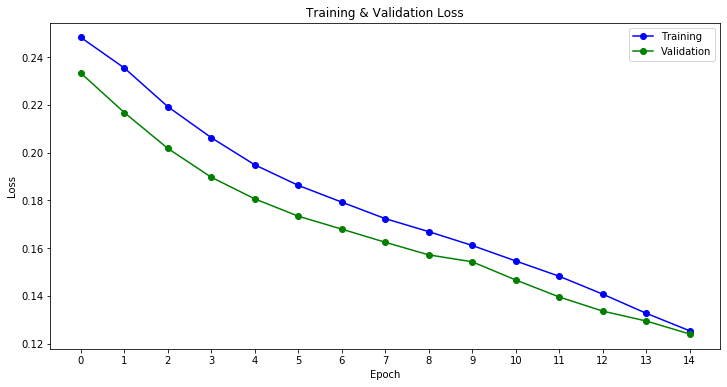

In [39]:
plt.figure(figsize=(12,6))

# Plot the learning curve.
plt.plot(train_losses_per_epoch, 'b-o', label="Training")
plt.plot(val_losses_per_epoch, 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks(list(range(EPOCHS)))
plt.show()

In [40]:
#torch.save(model.state_dict(), 'savedAzureRoBertaClassification') # Save trained model weights

In [23]:
y = le.inverse_transform(np.array(t))
lab_enc = preprocessing.LabelEncoder()
Y = lab_enc.fit_transform(y)

In [24]:
le_name_mapping = dict(zip(lab_enc.classes_, lab_enc.transform(lab_enc.classes_)))
print(le_name_mapping)

{'DISGUST High': 0, 'DISGUST Low': 1, 'DISGUST Moderate': 2, 'EMBARESSMENT High': 3, 'EMBARESSMENT Low': 4, 'EMBARESSMENT Moderate': 5, 'JOY High': 6, 'JOY Low': 7, 'JOY Moderate': 8, 'RISK High': 9, 'RISK Low': 10, 'RISK Moderate': 11, 'SADNESS High': 12, 'SADNESS Low': 13, 'SADNESS Moderate': 14}


In [25]:
# Format G1 embeddings
f = torch.cat(e, dim=0)
print(len(f))
print(f.shape)

412
torch.Size([412, 768])


In [ ]:
# Convert attention output from dim=(batch,layer,doc,head,len,len) to dim=(doc,layer,head,len,len)
#def process_attention_output(attention_output):
#    attentions = []
#    for layerset in range(len(attention_output)):
#        layer_set=[]
#        for layer in range(len(attention_output[layerset])):
#            layer_set.append(attention_output[layerset][layer].cpu().detach().numpy())
#        layer_set = np.asarray(layer_set)
#        layer_set = layer_set.swapaxes(0,1)
#        attentions.extend(layer_set)
#    attentions = np.asarray(attentions)
#    print(attentions.shape)
#    return attentions

In [ ]:
#atts = process_attention_output(atts)

In [26]:
import umap
reducer = umap.UMAP(metric='cosine')
embedding = reducer.fit_transform(f)
embedding.shape

(412, 2)

Text(0.5, 1.0, 'UMAP projection of Tuned Bert Embeddings')

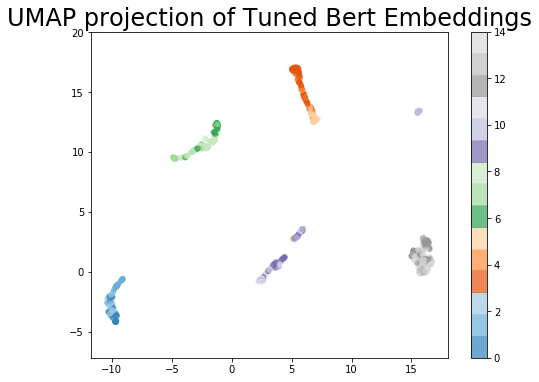

In [27]:
plt.figure(figsize=(8,6))
plt.scatter(embedding[:, 0], embedding[:, 1], c=Y, edgecolor='none', alpha=0.7, cmap=plt.cm.get_cmap('tab20c', 15))
plt.colorbar()
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of tuned Bert Embeddings', fontsize=24)

Text(0.5, 1.0, 't-SNE projection of Untuned Bert Embeddings')

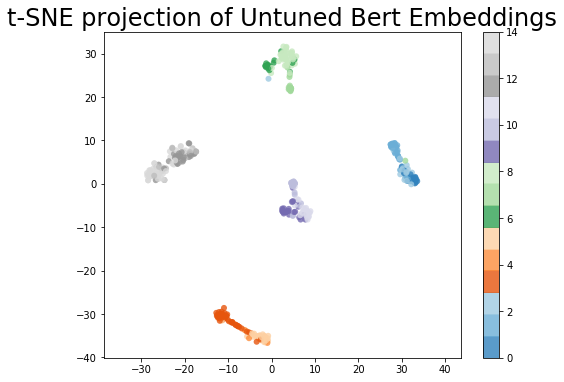

In [46]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(f)

plt.figure(figsize=(8,6))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=Y, edgecolor='none', alpha=0.8, cmap=plt.cm.get_cmap('tab20c', 15))
plt.colorbar()
plt.gca().set_aspect('equal', 'datalim')
plt.title('t-SNE projection of tuned Bert Embeddings', fontsize=24)

In [28]:
from sklearn.decomposition import PCA, KernelPCA
from sklearn.neighbors import NearestCentroid

def features_to_components_and_centroids(features, centroid_labels, n_components, kernel):
    pca = KernelPCA(n_components=n_components,kernel=kernel)
    projected = pca.fit_transform(features)
    # Find centroids of clusters
    clf = NearestCentroid()
    clf.fit(projected, centroid_labels)
    return projected, clf.centroids_

In [29]:
# G1 principal components and centroids
projected, centroids = features_to_components_and_centroids(f, Y, 20, 'cosine')

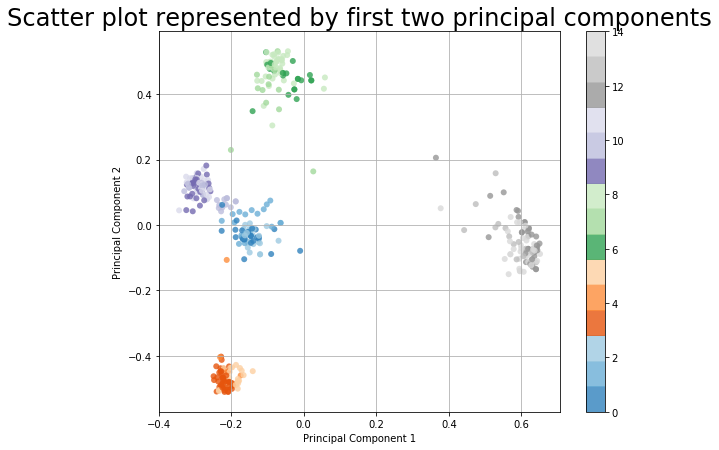

In [30]:
# Create scatter plot after PCA
plt.figure(figsize=(9,7))
plt.title('Scatter plot represented by first two principal components', fontsize=24)
plt.scatter(projected[:, 0], projected[:, 1],
            c=Y, edgecolor='none', alpha=0.8,
            cmap=plt.cm.get_cmap('tab20c', 15));
plt.grid()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar();
plt.show()

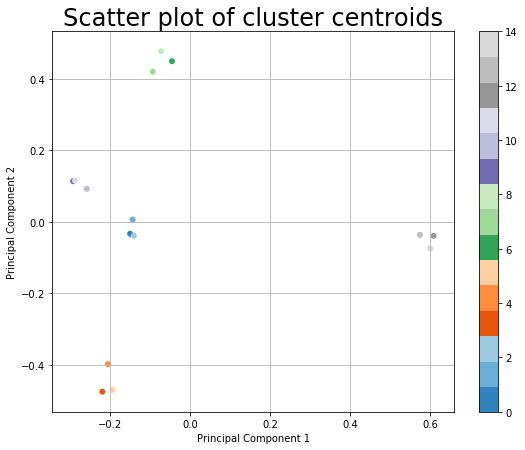

In [32]:
plt.figure(figsize=(9,7))
plt.title('Scatter plot of cluster centroids', fontsize=24)
plt.scatter(centroids[:,0],centroids[:,1],
            c=list(range(15)), edgecolor='none',
            cmap=plt.cm.get_cmap('tab20c', 15));
plt.grid()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar();
plt.show()

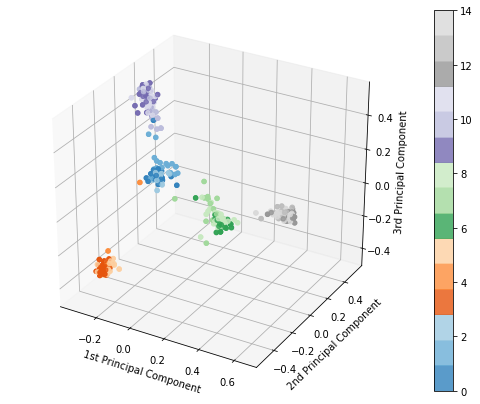

In [33]:
from mpl_toolkits import mplot3d

# Create the figure
fig = plt.figure(figsize=(9,7))
ax = plt.axes(projection='3d')

# Plot the values
ax.scatter3D(projected[:, 0], projected[:, 1], projected[:, 2],
            c=Y, alpha=0.8,
            cmap=plt.cm.get_cmap('tab20c', 15));
ax.set_xlabel('1st Principal Component')
ax.set_ylabel('2nd Principal Component')
ax.set_zlabel('3rd Principal Component')
fig.colorbar(ax.scatter3D(projected[:, 0], projected[:, 1], projected[:, 2],
            c=Y, alpha=0.8,
            cmap=plt.cm.get_cmap('tab20c', 15)))

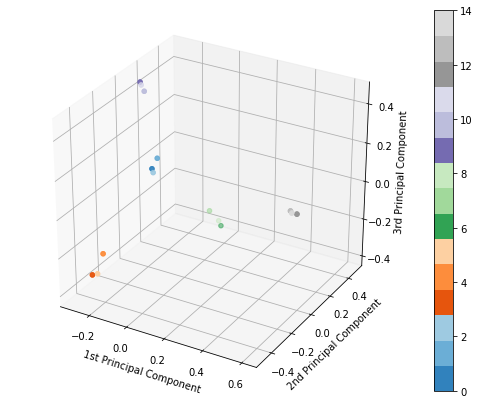

In [34]:
# Plot centroids
fig = plt.figure(figsize=(9,7))
ax = plt.axes(projection='3d')
ax.scatter3D(centroids[:,0],centroids[:,1],centroids[:,2],
            c=list(range(15)),
            cmap=plt.cm.get_cmap('tab20c', 15));
ax.set_xlabel('1st Principal Component')
ax.set_ylabel('2nd Principal Component')
ax.set_zlabel('3rd Principal Component')
fig.colorbar(ax.scatter3D(centroids[:,0],centroids[:,1],centroids[:,2],
            c=list(range(15)),
            cmap=plt.cm.get_cmap('tab20c', 15)))
#print(centroids)

# Push tracked data through model

### Push G0 testing set

In [35]:
testing_loader = DataLoader(g0_testing_set, **test_params)
#g0outputs, g0targets, g0pooled, g0attentions, g0val_loss = validation(0)
g0outputs, g0targets, g0pooled, g0val_loss = validation(0)

g0outputs = np.array(g0outputs)
for i, array in enumerate(g0outputs):
    g0outputs[i] = array == max(array)
g0targets = np.array(g0targets)
g0_accuracy = metrics.accuracy_score(g0targets, g0outputs)
g0_f1_score_micro = metrics.f1_score(g0targets, g0outputs, average='micro')
g0_f1_score_macro = metrics.f1_score(g0targets, g0outputs, average='macro')
print(f'===== G0 testing set Performance =====')
print(f"Accuracy Score = {g0_accuracy}")
print(f"F1 Score (Micro) = {g0_f1_score_micro}")
print(f"F1 Score (Macro) = {g0_f1_score_macro}")
    
g0y = le.inverse_transform(np.array(g0targets))
#lab_enc = preprocessing.LabelEncoder()
g0Y = lab_enc.transform(g0y)

#le_name_mapping = dict(zip(lab_enc.classes_, lab_enc.transform(lab_enc.classes_)))
#print(le_name_mapping)

g0f = torch.cat(g0pooled, dim=0) # G0 embeddings
print(len(g0f))
print(g0f.shape)

Epoch: 1, Validation Loss:  0.15587566105219033
===== G0 testing set Performance =====
Accuracy Score = 0.4538834951456311
F1 Score (Micro) = 0.4538834951456311
F1 Score (Macro) = 0.24773164411959608
412
torch.Size([412, 768])


In [42]:
# G0 principal components and centroids
g0projected, g0centroids = features_to_components_and_centroids(g0f, g0Y, 20, 'cosine')
# Convert attention output from dim=(batch,layer,doc,head,len,len) to dim=(doc,layer,head,len,len)
#g0attentions = process_attention_output(g0attentions)

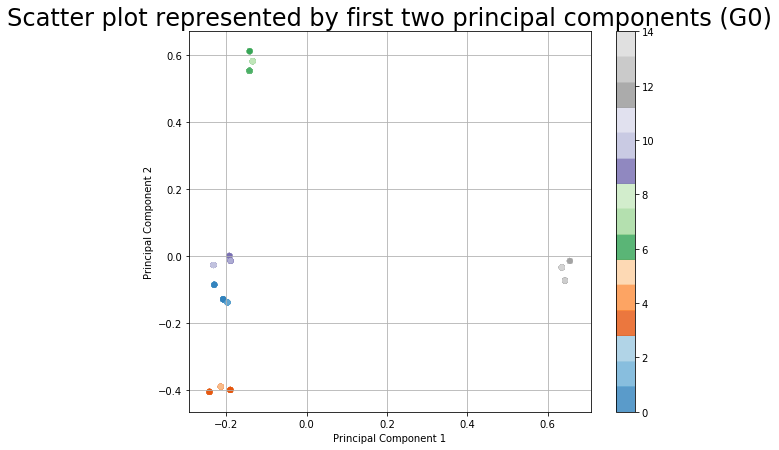

In [43]:
# Create scatter plot after PCA
plt.figure(figsize=(9,7))
plt.title('Scatter plot represented by first two principal components (G0)', fontsize=24)
plt.scatter(g0projected[:, 0], g0projected[:, 1],
            c=g0Y, edgecolor='none', alpha=0.8,
            cmap=plt.cm.get_cmap('tab20c', 15));
plt.grid()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar();
plt.show()

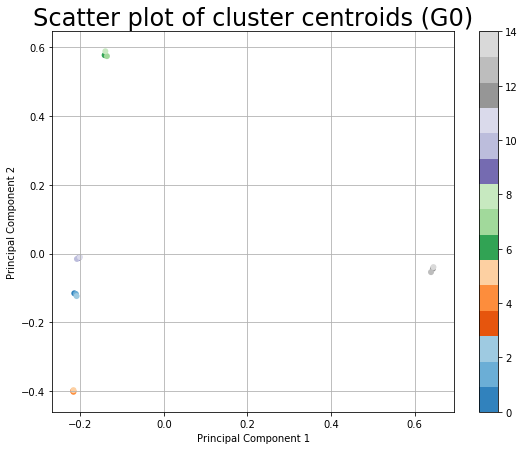

In [44]:
# Find centroids of clusters
plt.figure(figsize=(9,7))
plt.title('Scatter plot of cluster centroids (G0)', fontsize=24)
plt.scatter(g0centroids[:,0],g0centroids[:,1],
            c=list(range(15)), edgecolor='none',
            cmap=plt.cm.get_cmap('tab20c', 15));
plt.grid()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar();
plt.show()

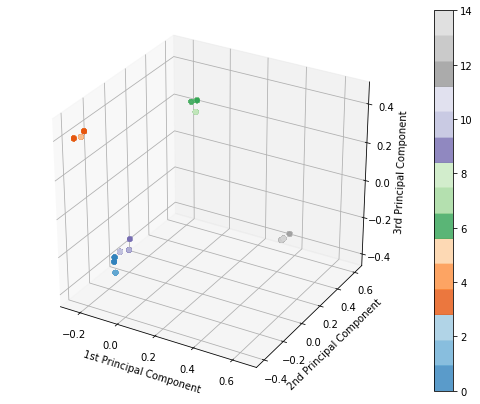

In [45]:
fig = plt.figure(figsize=(9,7))
ax = plt.axes(projection='3d')
ax.scatter3D(g0projected[:, 0], g0projected[:, 1], g0projected[:, 2],
            c=g0Y, alpha=0.8,
            cmap=plt.cm.get_cmap('tab20c', 15));
ax.set_xlabel('1st Principal Component')
ax.set_ylabel('2nd Principal Component')
ax.set_zlabel('3rd Principal Component')
fig.colorbar(ax.scatter3D(g0projected[:, 0], g0projected[:, 1], g0projected[:, 2],
            c=g0Y, alpha=0.8,
            cmap=plt.cm.get_cmap('tab20c', 15)))

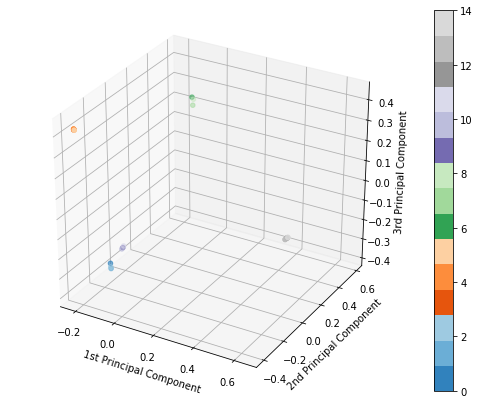

In [46]:
fig = plt.figure(figsize=(9,7))
ax = plt.axes(projection='3d')
ax.scatter3D(g0centroids[:,0],g0centroids[:,1],g0centroids[:,2],
            c=list(range(15)),
            cmap=plt.cm.get_cmap('tab20c', 15));
ax.set_xlabel('1st Principal Component')
ax.set_ylabel('2nd Principal Component')
ax.set_zlabel('3rd Principal Component')
fig.colorbar(ax.scatter3D(g0centroids[:,0],g0centroids[:,1],g0centroids[:,2],
            c=list(range(15)),
            cmap=plt.cm.get_cmap('tab20c', 15)))
#print(g0clf_3d.centroids_)

### Push G1 testing set

In [ ]:
testing_loader = DataLoader(g1_testing_set, **test_params)
#g1outputs, g1targets, g1pooled, g1attentions, g1val_loss = validation(0)
g1outputs, g1targets, g1pooled, g1val_loss = validation(0)

g1outputs = np.array(g1outputs)
for i, array in enumerate(g1outputs):
    g1outputs[i] = array == max(array)
g1targets = np.array(g1targets)
g1_accuracy = metrics.accuracy_score(g1targets, g1outputs)
g1_f1_score_micro = metrics.f1_score(g1targets, g1outputs, average='micro')
g1_f1_score_macro = metrics.f1_score(g1targets, g1outputs, average='macro')
print(f'===== G2 testing set Performance =====')
print(f"Accuracy Score = {g1_accuracy}")
print(f"F1 Score (Micro) = {g1_f1_score_micro}")
print(f"F1 Score (Macro) = {g1_f1_score_macro}")
    
g1y = le.inverse_transform(np.array(g1targets))
#lab_enc = preprocessing.LabelEncoder()
g1Y = lab_enc.transform(g1y)

#le_name_mapping = dict(zip(lab_enc.classes_, lab_enc.transform(lab_enc.classes_)))
#print(le_name_mapping)

g1f = torch.cat(g1pooled, dim=0)
print(len(g1f))
print(g1f.shape)

In [ ]:
# G1 principal components and centroids
g1projected, g1centroids = features_to_components_and_centroids(g1f, g1Y, 20, 'cosine')

### Push G2 testing set

In [48]:
testing_loader = DataLoader(g2_testing_set, **test_params)
#g2outputs, g2targets, g2pooled, g2attentions, g2val_loss = validation(0)
g2outputs, g2targets, g2pooled, g2val_loss = validation(0)

g2outputs = np.array(g2outputs)
for i, array in enumerate(g2outputs):
    g2outputs[i] = array == max(array)
g2targets = np.array(g2targets)
g2_accuracy = metrics.accuracy_score(g2targets, g2outputs)
g2_f1_score_micro = metrics.f1_score(g2targets, g2outputs, average='micro')
g2_f1_score_macro = metrics.f1_score(g2targets, g2outputs, average='macro')
print(f'===== G2 testing set Performance =====')
print(f"Accuracy Score = {g2_accuracy}")
print(f"F1 Score (Micro) = {g2_f1_score_micro}")
print(f"F1 Score (Macro) = {g2_f1_score_macro}")
    
g2y = le.inverse_transform(np.array(g2targets))
#lab_enc = preprocessing.LabelEncoder()
g2Y = lab_enc.transform(g2y)

#le_name_mapping = dict(zip(lab_enc.classes_, lab_enc.transform(lab_enc.classes_)))
#print(le_name_mapping)

g2f = torch.cat(g2pooled, dim=0) # G2 embeddings
print(len(g2f))
print(g2f.shape)

Epoch: 1, Validation Loss:  0.15224062250210688
===== G2 testing set Performance =====
Accuracy Score = 0.49514563106796117
F1 Score (Micro) = 0.49514563106796117
F1 Score (Macro) = 0.3928378503386489
412
torch.Size([412, 768])


In [49]:
# G2 principal components and centroids
g2projected, g2centroids = features_to_components_and_centroids(g2f, g2Y, 20, 'cosine')
# Convert attention output from dim=(batch,layer,doc,head,len,len) to dim=(doc,layer,head,len,len)
#g2attentions = process_attention_output(g2attentions)

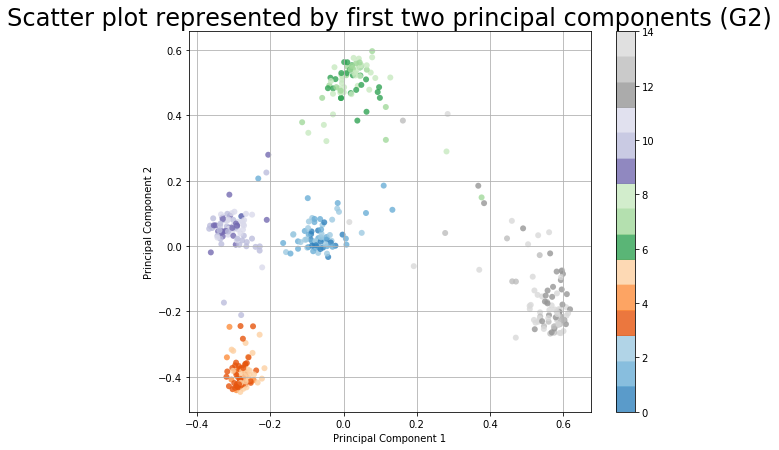

In [50]:
# Create scatter plot after PCA
plt.figure(figsize=(9,7))
plt.title('Scatter plot represented by first two principal components (G2)', fontsize=24)
plt.scatter(g2projected[:, 0], g2projected[:, 1],
            c=g2Y, edgecolor='none', alpha=0.8,
            cmap=plt.cm.get_cmap('tab20c', 15));
plt.grid()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar();
plt.show()

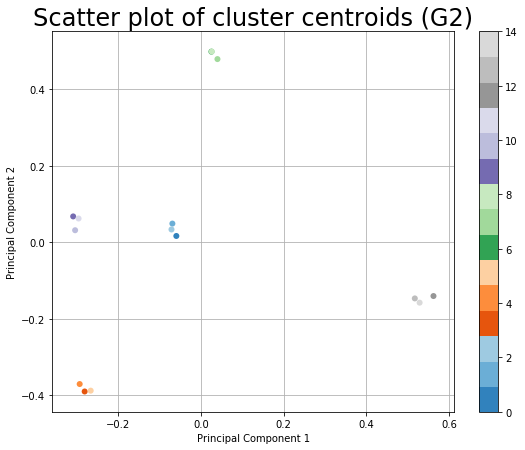

In [51]:
# Find centroids of clusters
plt.figure(figsize=(9,7))
plt.title('Scatter plot of cluster centroids (G2)', fontsize=24)
plt.scatter(g2centroids[:,0],g2centroids[:,1],
            c=list(range(15)), edgecolor='none',
            cmap=plt.cm.get_cmap('tab20c', 15));
plt.grid()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar();
plt.show()

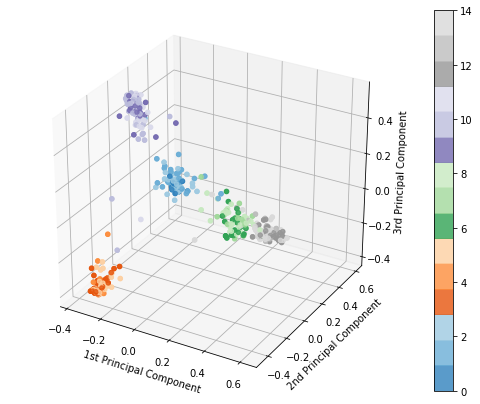

In [52]:
fig = plt.figure(figsize=(9,7))
ax = plt.axes(projection='3d')
ax.scatter3D(g2projected[:, 0], g2projected[:, 1], g2projected[:, 2],
            c=g2Y, alpha=0.8,
            cmap=plt.cm.get_cmap('tab20c', 15));
ax.set_xlabel('1st Principal Component')
ax.set_ylabel('2nd Principal Component')
ax.set_zlabel('3rd Principal Component')
fig.colorbar(ax.scatter3D(g2projected[:, 0], g2projected[:, 1], g2projected[:, 2],
            c=g2Y, alpha=0.8,
            cmap=plt.cm.get_cmap('tab20c', 15)))

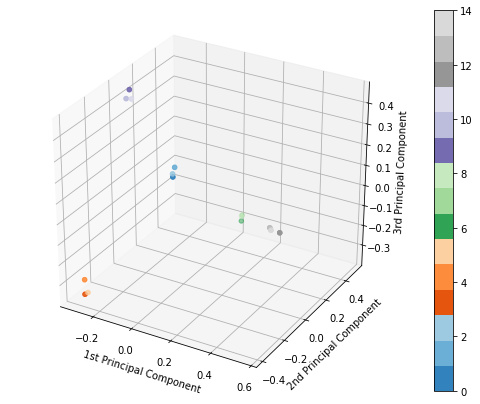

In [53]:
fig = plt.figure(figsize=(9,7))
ax = plt.axes(projection='3d')

# Plot the values
ax.scatter3D(g2centroids[:,0],g2centroids[:,1],g2centroids[:,2],
            c=list(range(15)),
            cmap=plt.cm.get_cmap('tab20c', 15));
ax.set_xlabel('1st Principal Component')
ax.set_ylabel('2nd Principal Component')
ax.set_zlabel('3rd Principal Component')
fig.colorbar(ax.scatter3D(g2centroids[:,0],g2centroids[:,1],g2centroids[:,2],
            c=list(range(15)),
            cmap=plt.cm.get_cmap('tab20c', 15)))
#print(g2clf_3d.centroids_)

### Push G3 testing set

In [54]:
testing_loader = DataLoader(g3_testing_set, **test_params)
#g3outputs, g3targets, g3pooled, g3attentions, g3val_loss = validation(0)
g3outputs, g3targets, g3pooled, g3val_loss = validation(0)

g3outputs = np.array(g3outputs)
for i, array in enumerate(g3outputs):
    g3outputs[i] = array == max(array)
g3targets = np.array(g3targets)
g3_accuracy = metrics.accuracy_score(g3targets, g3outputs)
g3_f1_score_micro = metrics.f1_score(g3targets, g3outputs, average='micro')
g3_f1_score_macro = metrics.f1_score(g3targets, g3outputs, average='macro')
print(f'===== G2 testing set Performance =====')
print(f"Accuracy Score = {g3_accuracy}")
print(f"F1 Score (Micro) = {g3_f1_score_micro}")
print(f"F1 Score (Macro) = {g3_f1_score_macro}")
    
g3y = le.inverse_transform(np.array(g3targets))
#lab_enc = preprocessing.LabelEncoder()
g3Y = lab_enc.transform(g3y)

#le_name_mapping = dict(zip(lab_enc.classes_, lab_enc.transform(lab_enc.classes_)))
#print(le_name_mapping)

g3f = torch.cat(g3pooled, dim=0) # G3 embeddings
print(len(g3f))
print(g3f.shape)

Epoch: 1, Validation Loss:  0.15957884031992692
===== G2 testing set Performance =====
Accuracy Score = 0.470873786407767
F1 Score (Micro) = 0.470873786407767
F1 Score (Macro) = 0.37056093822424263
412
torch.Size([412, 768])


In [55]:
# G3 principal components and centroids
g3projected, g3centroids = features_to_components_and_centroids(g3f, g3Y, 20, 'cosine')
# Convert attention output from dim=(batch,layer,doc,head,len,len) to dim=(doc,layer,head,len,len)
#g3attentions = process_attention_output(g3attentions)

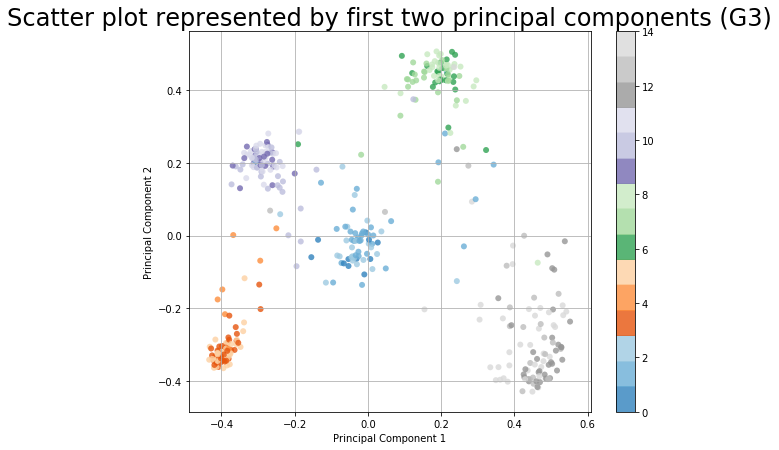

In [56]:
# Create scatter plot after PCA
plt.figure(figsize=(9,7))
plt.title('Scatter plot represented by first two principal components (G3)', fontsize=24)
plt.scatter(g3projected[:, 0], g3projected[:, 1],
            c=g3Y, edgecolor='none', alpha=0.8,
            cmap=plt.cm.get_cmap('tab20c', 15));
plt.grid()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar();
plt.show()

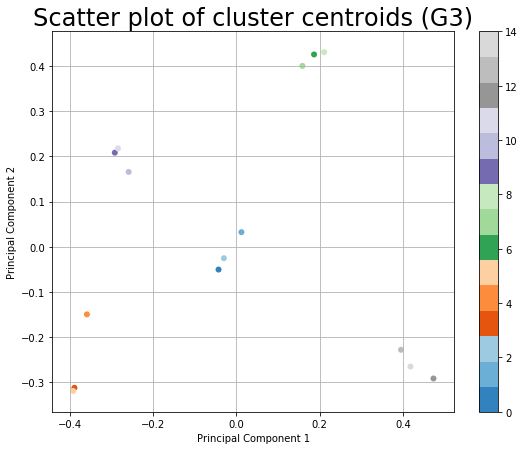

In [57]:
# Find centroids of clusters
plt.figure(figsize=(9,7))
plt.title('Scatter plot of cluster centroids (G3)', fontsize=24)
plt.scatter(g3centroids[:,0],g3centroids[:,1],
            c=list(range(15)), edgecolor='none',
            cmap=plt.cm.get_cmap('tab20c', 15));
plt.grid()
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar();
plt.show()

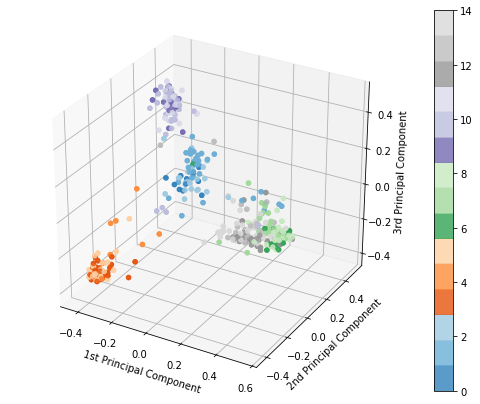

In [58]:
fig = plt.figure(figsize=(9,7))
ax = plt.axes(projection='3d')
ax.scatter3D(g3projected[:, 0], g3projected[:, 1], g3projected[:, 2],
            c=g3Y, alpha=0.8,
            cmap=plt.cm.get_cmap('tab20c', 15));
ax.set_xlabel('1st Principal Component')
ax.set_ylabel('2nd Principal Component')
ax.set_zlabel('3rd Principal Component')
fig.colorbar(ax.scatter3D(g3projected[:, 0], g3projected[:, 1], g3projected[:, 2],
            c=g3Y, alpha=0.8,
            cmap=plt.cm.get_cmap('tab20c', 15)))

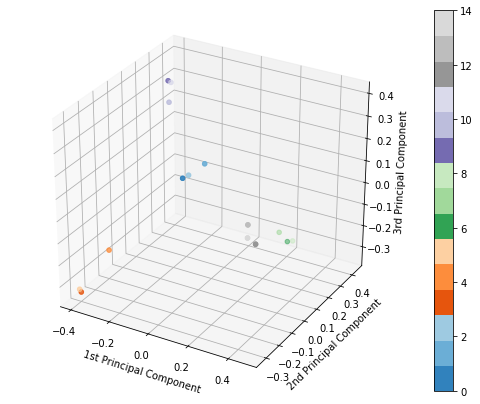

In [59]:
fig = plt.figure(figsize=(9,7))
ax = plt.axes(projection='3d')
ax.scatter3D(g3centroids[:,0],g3centroids[:,1],g3centroids[:,2],
            c=list(range(15)),
            cmap=plt.cm.get_cmap('tab20c', 15));
ax.set_xlabel('1st Principal Component')
ax.set_ylabel('2nd Principal Component')
ax.set_zlabel('3rd Principal Component')
fig.colorbar(ax.scatter3D(g3centroids[:,0],g3centroids[:,1],g3centroids[:,2],
            c=list(range(15)),
            cmap=plt.cm.get_cmap('tab20c', 15)))
#print(g3clf_3d.centroids_)

## Plot shifts in vector space across generations

In [89]:
# Set dimension to plot along
x, y, z = 0, 1, 2
# Set colormap
colormap = 'tab20c'
# Class indices
ALL = range(15)
HIGH = [0,3,6,9,12]
MODERATE = [2,5,8,11,14]
LOW = [1,4,7,10,13]

In [94]:
plot_setting = LOW

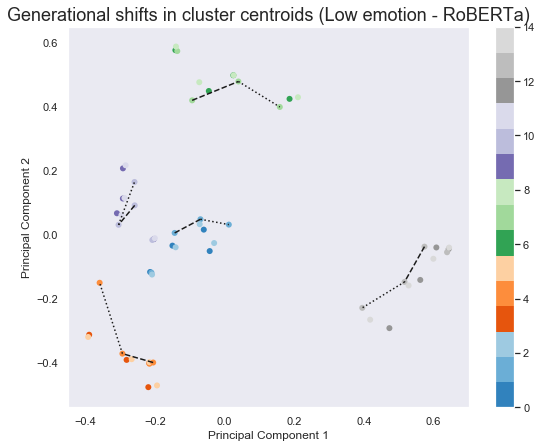

In [95]:
plt.figure(figsize=(9,7))
plt.title('Generational shifts in cluster centroids (Low emotion - RoBERTa)', fontsize=18)

plt.scatter(g0centroids[:,x],g0centroids[:,y],
            c=list(range(15)), edgecolor='none',
            cmap=plt.cm.get_cmap(colormap, 15));

plt.scatter(centroids[:,x],centroids[:,y],
            c=list(range(15)), edgecolor='none',
            cmap=plt.cm.get_cmap(colormap, 15));

plt.scatter(g2centroids[:,x],g2centroids[:,y],
            c=list(range(15)), edgecolor='none',
            cmap=plt.cm.get_cmap(colormap, 15));

plt.scatter(g3centroids[:,x],g3centroids[:,y],
            c=list(range(15)), edgecolor='none',
            cmap=plt.cm.get_cmap(colormap, 15));

# Plot G0 to G1
for i in plot_setting:
    plt.plot([g0centroids[i,x],centroids[i,x]],[g0centroids[i,y],centroids[i,y]],'k-')#,label='G0->G1')
# Plot G1 to G2
for i in plot_setting:
    plt.plot([centroids[i,x],g2centroids[i,x]],[centroids[i,y],g2centroids[i,y]],'k--')#,label='G1->G2')
# Plot G2 to G3
for i in plot_setting:
    plt.plot([g2centroids[i,x],g3centroids[i,x]],[g2centroids[i,y],g3centroids[i,y]],'k:')#,label='G2->G3')

plt.grid()
plt.xlabel(f'Principal Component {x+1}')
plt.ylabel(f'Principal Component {y+1}')
plt.colorbar()
#plt.legend()
plt.show()


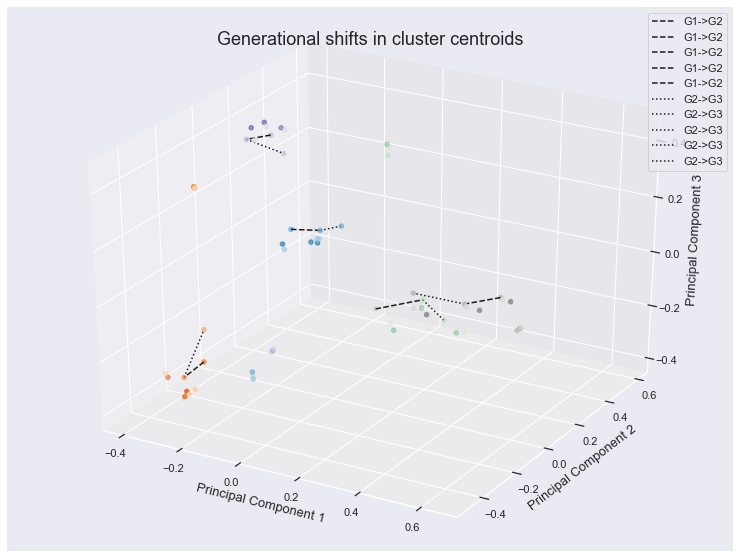

In [96]:
# Create the figure
fig = plt.figure(figsize=(13,10))
ax = plt.axes(projection='3d')
plt.title('Generational shifts in cluster centroids', fontsize=18)
# Plot the values
ax.scatter3D(g0centroids[:,x],g0centroids[:,y],g0centroids[:,z],
            c=list(range(15)),
            cmap=plt.cm.get_cmap(colormap, 15));
ax.scatter3D(centroids[:,x],centroids[:,y],centroids[:,z],
            c=list(range(15)),
            cmap=plt.cm.get_cmap(colormap, 15));
ax.scatter3D(g2centroids[:,x],g2centroids[:,y],g2centroids[:,z],
            c=list(range(15)),
            cmap=plt.cm.get_cmap(colormap, 15));
ax.scatter3D(g3centroids[:,x],g3centroids[:,y],g3centroids[:,z],
            c=list(range(15)),
            cmap=plt.cm.get_cmap(colormap, 15));

# Plot G0 to G1
for i in plot_setting:
    ax.plot([g0centroids[i,x],centroids[i,x]],
            [g0centroids[i,y],centroids[i,y]],
            [g0centroids[i,z],centroids[i,z]],'k-',label='G0->G1')
# Plot G1 to G2
for i in plot_setting:
    ax.plot([centroids[i,x],g2centroids[i,x]],
            [centroids[i,y],g2centroids[i,y]],
            [centroids[i,z],g2centroids[i,z]],'k--',label='G1->G2')
# Plot G2 to G3
for i in plot_setting:
    ax.plot([g2centroids[i,x],g3centroids[i,x]],
            [g2centroids[i,y],g3centroids[i,y]],
            [g2centroids[i,z],g3centroids[i,z]],'k:',label='G2->G3')

ax.set_xlabel(f'Principal Component {x+1}',fontsize=13)
ax.set_ylabel(f'Principal Component {y+1}',fontsize=13)
ax.set_zlabel(f'Principal Component {z+1}',fontsize=13)
ax.legend()
#fig.colorbar(ax.scatter3D(g3centroids[:,x],g3centroids[:,y],g3centroids[:,z],
#            c=list(range(15)),
#            cmap=plt.cm.get_cmap(colormap, 15)))

In [72]:
pca95 = PCA(n_components = 0.95)
pca95.fit(f)
print("Number of components that explains 95% of variance: ",pca95.n_components_)

Number of components that explains 95% of variance:  16


In [73]:
g1pca8 = KernelPCA(n_components=20,kernel='cosine')
g1pca8.fit(f)
g1projected_8 = g1pca8.transform(f)

In [74]:
g1_affect_rating = g1df['G1 Affect Rating'].values[id_Xtr]
g1_affect_rating = g1_affect_rating[validation_indices]
g1_wc = g1df['G1 WC'].values[id_Xtr]
g1_wc = g1_wc[validation_indices]
g1_emotional_effect = g1df['G1 emotional effect'].values[id_Xtr]
g1_emotional_effect = g1_emotional_effect[validation_indices]
g1_transport = g1df['G1 Transport'].values[id_Xtr]
g1_transport = g1_transport[validation_indices]
g1_event_presence = g1df['G1 Event Presence'].values[id_Xtr]
g1_event_presence = g1_event_presence[validation_indices]

corr_features = {'pc1':g1projected_8[:,0], 'pc2':g1projected_8[:,1], 'pc3':g1projected_8[:,2], 'pc4':g1projected_8[:,3], 
                 'pc5':g1projected_8[:,4], 'pc6':g1projected_8[:,5], 'pc7':g1projected_8[:,6], 'pc8':g1projected_8[:,7],
                 'pc9':g1projected_8[:,8], 'pc10':g1projected_8[:,9], 'pc11':g1projected_8[:,10], 'pc12':g1projected_8[:,11],
                 'pc13':g1projected_8[:,12], 'pc14':g1projected_8[:,13], 'pc15':g1projected_8[:,14], 'pc16':g1projected_8[:,15],
                 'pc17':g1projected_8[:,16], 'pc18':g1projected_8[:,17], 'pc19':g1projected_8[:,18], 'pc20':g1projected_8[:,19],
                'g1_affect_rating':g1_affect_rating, 'g1_wc':g1_wc, 'g1_emotional_effect':g1_emotional_effect,
                'g1_transport':g1_transport, 'g1_event_presence':g1_event_presence}

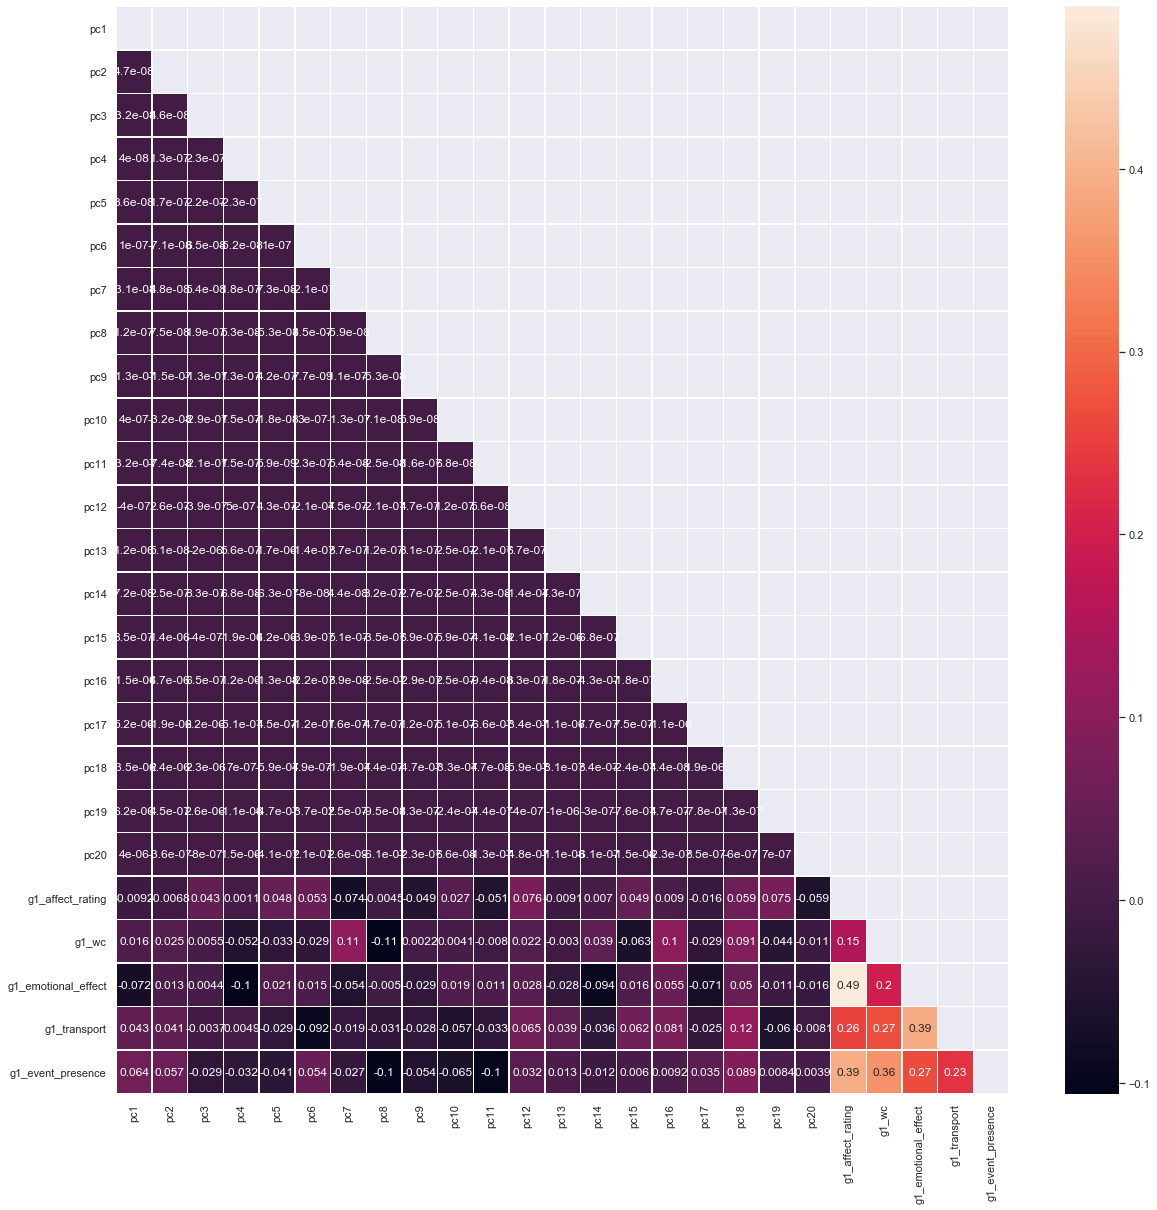

In [75]:
corr_features = pd.DataFrame.from_dict(corr_features)
# Plot the correlation coefficient matrix as a heat map
corr = corr_features.corr()
mask = np.triu(np.ones_like(corr, dtype=np.bool))
sns.set()
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(corr, mask=mask, annot=True, linewidths=.5, ax=ax)

In [131]:
#torch.save(model.state_dict(), 'savedRoBertaClassification')